# Exercise 2 - Q-learning
In this exercise, we will train our own agent using tabular [Q-learning](https://www.youtube.com/watch?v=__t2XRxXGxI) to solve the [Cliff Walking task](https://gymnasium.farama.org/environments/toy_text/cliff_walking/). Q-learning is a popular method for model-free control. Our goal is to the learn the optimal action-value function $Q^*(s, a)$ for a given state $s$ and action $a$, by iteratively sampling from the environment and updating our current Q-estimate. To represent the Q-function, we use a table, where we store an estimate for each state and action.

In contrast to behavior cloning, we do not have the correct actions available for our states. We only get a reward signal and have to actively search for the best behavior.

<img src="cliff_walking.gif" alt="Cliff Walking" width="60%"/>


_Agent using random actions to play Cliff walking_

## 0 Setup
These are the same packages as in the last exercise:

In [4]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio
!pip install pygame

   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.8 MB 640.0 kB/s eta 0:00:17
    --------------------------------------- 0.2/10.8 MB 1.8 MB/s eta 0:00:06
   - -------------------------------------- 0.5/10.8 MB 4.0 MB/s eta 0:00:03
   ---- ----------------------------------- 1.1/10.8 MB 6.8 MB/s eta 0:00:02
   ----- ---------------------------------- 1.5/10.8 MB 6.9 MB/s eta 0:00:02
   ------- -------------------------------- 2.1/10.8 MB 7.9 MB/s eta 0:00:02
   --------- ------------------------------ 2.4/10.8 MB 8.2 MB/s eta 0:00:02
   ---------- ----------------------------- 2.7/10.8 MB 8.3 MB/s eta 0:00:01
   ----------- ---------------------------- 3.0/10.8 MB 8.0 MB/s eta 0:00:01
   ------------ --------------------------- 3.3/10.8 MB 7.8 MB/s eta 0:00:01
   ------------- -------------------------- 3.7/10.8 MB 7.8 MB/s eta 0:00:01
   --------------- ------------------------ 4.2/10.8 MB 8.4 MB/s eta 0:00:01
   -

In [1]:
# Imports
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable, Dict
from PIL import Image
from collections import defaultdict, namedtuple
import itertools
import pandas as pd

## 1 Reinforcement Learning

In Reinforcement Learning (RL), there is an interaction loop between an agent making decisions and an environment, which represents the world the agent is interacting with. After the agent performs an action like moving left or right, the environment returns the next state e.g. the next frame in a video game, and a reward, a scalar value that tells the agent how well the current state is. For example, scoring points might earn the agent a positive reward.

<img src="agent_env_interaction.svg" alt="agent environment interaction" width="40%"/>

---
<span style="color:orange">**EXERCISE**</span>: **RL Warm-up** (6 points)
1. Name a key difference between Reinforcement Learning and Deep Learning.  
2. Define a Markov decision process (MDP).
3. Explain the concept of policy $\pi$ in the context of RL. Given a policy, what does the action value $Q_{\pi}(s,a)$ describe?
4. What do we mean by the exploration and exploitation trade-off . Why can we not focus exclusively on one? 
5. What is the difference between model-based and model-free methods?

**Your answers:**
1. Deep Learning is concerned with deep neural networks (networks with many layers) while Reinforcement Learning deals with sequential decision making. (1 point) Both, however, can be used together.
2. A tuple $(S, A, P, R, y, p_0)$ with (0.5 for each correct description):
    - $S$  (finite) set of states
    - $A$ (finite) set of actions
    - $P(s' | s, a) = P(S_{t+1} = s’ | S_t = s, A_t = a)$ state transition probability. The next state depends on the current state and action, and the Markov property holds.
    - $R$ the reward function, $r = R(s, a)$. Be aware we define the the reward function with current state and action, but a defintion with next state $R(s, a, s')$ is also possible

    Alternative to $P$ and $R$:
    - $P(s’ ,r| s, a)$ Four-argument dynamics function with both reward and next state and optionally a set of rewards $R$.

    optional (no points):
    - $y ∈ [0, 1]$ discount factor
    - $p_0$ initial state distribution $P(S_0 = s)$ for all $s$

    (2 points)
3. In RL, a policy $\pi$ is a function defining the behavior of the agent. It maps states to actions or action probabilities (0.5 points) The action-value function describes the expected return starting from state $s$ performing an action $a$ and then following the policy $\pi$. (0.5 points)

4. To maximize its return, an agent should take the currently best known action (exploitation), but to gain knowledge about which action is best, the agent must try different actions (exploration), possibly many times. Neither can be done exclusively to solve the task, leading to a trade-off. (1 point) Only exploitation would lead us to possibly miss an even better action, while only exploration would lead us to behave suboptimally. (0.5 points)

5. Whether the method uses a model (model-based) or not (model-free) (0.5 points)

# 2 Gymnasium
In Python, we can represent the RL loop using the [Gymnasium interface](https://gymnasium.farama.org/). In the following, we give a short introduction into the library Gymnasium.


## 2.1 Interacting with the Environment
First, we create our environment using the `gym.make()` command, specifying the environment's name as a string. In our example, we're using the Cliff Walking task, where an agent must walk to a goal without falling from the cliff. For every step the agent takes, he receives a reward of $-1$. When the agent falls of the cliff he must start from the beginning and receives a reward of $-100$.

Once the environment is created, we reset it to the initial state with `env.reset()`. This function returns two values. The first is the initial state, which for our task is represented by an integer ranging from $0$ to $48$ describing all the positions the agent can be in as the game is played out on a $4\times12$ map. Note, although we will refer to the state as `observation`, you can still think of both being the same for our task. The second value provides extra debugging information, but we will not be using it.

Finally, we can visualize the current state using `env.render()`. Since we specified `render_mode="rgb_array"`, this function returns an RGB image that we can display.

Current state is: 36


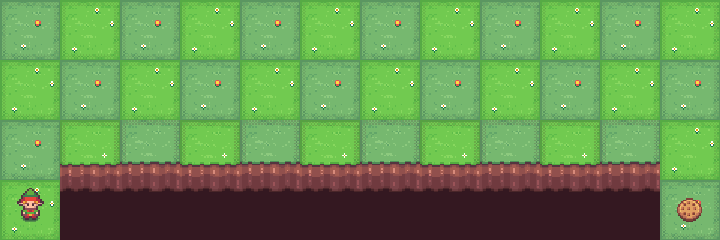

In [2]:
# Create the environment
env = gym.make("CliffWalking-v0", render_mode="rgb_array")

# Reset and the agent receives the first observation and additional info
obs, info = env.reset()
print(f"Current state is: {obs}") # Location [x=0, y=3] -> 0 + 3 * 12 = 36.

# Render current state
img = env.render()
Image.fromarray(img)

We define the behavior of our agent using a policy that takes the current observation (state) as input and gives us an action as output: $\pi(s) = a$. Once we decided on an action using our policy, we can simulate the environment for one timestep using `env.step(action)`. This function returns the next observation and the reward for the action we took. Further variables are returned, like whether the environment terminated e.g. we reached the goal, if the episode was truncated, and some extra information.


Performing action: MOVE RIGHT
next_state: 36, reward: -100, state: 36, action: 1, done: False
Performing action: MOVE LEFT
next_state: 36, reward: -1, state: 36, action: 3, done: False


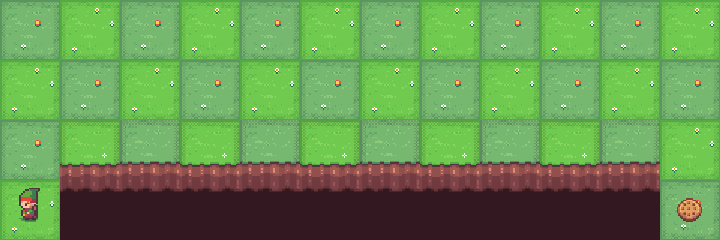

In [3]:
# Actions to control agent
ACTIONS = {
    0: "MOVE UP",
    1: "MOVE RIGHT",
    2: "MOVE DOWN",
    3: "MOVE LEFT",
}

def random_policy(obs: int) -> int:
    """A policy that performs random actions."""
    return np.random.randint(4)

# Simulate for two time steps
TIME_STEPS = 2
for i in range(TIME_STEPS):
    action = random_policy(obs)
    print(f"Performing action: {ACTIONS[action]}")
    next_obs, reward, terminated, truncated, info = env.step(action)
    print(f"next_state: {next_obs}, reward: {reward}, state: {obs}, action: {action}, done: {terminated or truncated}")
    obs = next_obs

img = env.render()
Image.fromarray(img)

<span style="color:orange">**EXERCISE**</span>: **Environment Sampling** (3 points, -0.5 for every mistake)

Implement the `sample` function, which simulates the environment for a specified number of time steps and returns the average undiscounted sum of rewards per finished episode. Note, if `env.step` returns that either termination or truncation is true, the current episode ends, but the environment will not auto-reset itself.



In [4]:
def sample(env: gym.Env, policy: Callable[[int], int], num_steps: int = 100_000) -> float:
    """
    Samples for a num_steps and returns the average undiscounted sum of rewards per episode.

    :param env: The Cliff Walking environment. Note: may not have been reset.
    :param policy: A function that maps from observations to actions.
    :param num_steps: The number of steps to sample.
    :returns: Average undiscounted return per episode, unfinished episodes are not counted.
    """
    # Init list of episode returns and current return
    eps_rets = []
    curr_ret = 0
    obs, _ = env.reset()

    for _ in range(num_steps):
        # Get action and observe next obs
        action = policy(obs)
        obs, rew, terminated, truncated, _ = env.step(action)
        curr_ret += rew

        # Check if episode ends
        if terminated or truncated:
            obs, _ = env.reset()
            eps_rets.append(curr_ret)
            curr_ret = 0

    return np.mean(eps_rets)

undiscounted_return = sample(env, random_policy, num_steps=100_000)
print(f"The policy has an average undiscounted return of {undiscounted_return}")


The policy has an average undiscounted return of -54051.166666666664


## 2.2 Action and observation spaces
Environments specify the formats of their valid actions and observations using `env.action_space` and `env.observation_space`, respectively. These fields use instances of the [Space](https://gymnasium.farama.org/api/spaces/) class, offering a variety of space definitions. Interesting for us are:
- `Discrete(n=.., start=0)`: Discrete space, where the values are between `start` (inclusive) and `n` (exclusive).
- `Box(low=.., high=.., shape=.., dtype=..)`: Either continuous or discrete space based on the dtype. The values are bound between `low` and `high` and have the specified shape.


In [5]:
# Print observation and action space of Cliff Walking
env_cliff_walking = gym.make("CliffWalking-v0")

print(f"Observation space of Cliff Walking Env: {env.observation_space}")
print(f"Action space of Cliff Walking Env: {env.action_space}")

# Other environments also have these attributes
env_breakout = gym.make('MinAtar/Breakout-v1') # from the last exercise

print(f"Observation space of Breakout Env: {env_breakout.observation_space}")
print(f"Action space of Breakout Env: {env_breakout.action_space}")


Observation space of Cliff Walking Env: Discrete(48)
Action space of Cliff Walking Env: Discrete(4)
Observation space of Breakout Env: Box(False, True, (10, 10, 4), bool)
Action space of Breakout Env: Discrete(3)


These attributes give us information about our environment and enable us to design policies and value functions in such a way that they are compatible with the environment.

---
<span style="color:orange">**EXERCISE**</span>: **Cliff Walking MDP** (4 points)

Formalize the Cliff Walking Environment as Markov Decision Process.
Hint: You do not need to define the state transition and the reward function for each state individually, rather you can describe different scenarios and their rewards and probabilities. Also consider what happens if you are on the edge of the field or fall into the cliff.


**Your answer:** We define the CliffWalking MDP as tuple $(S, A, P, R)$ like we did in Task 1 and define the elements as follows:
- Set of states $S = \{0, 1, .., 47\}$ (0.5 points). Note, definitions of $S = \{1, 2, .., 48\}$ were also accepted.
- Set of actions $A = \{0, 1, 2, 3\}$ (0.5 points)
- Transition probability function
$P(s'|s, a) = 
\left\{ 
  \begin{array}{ c l }
    1 & \quad \textrm{specified in *}\\
    0  & \quad \textrm{otherwise}
  \end{array}
\right.$

\* if one of the following holds for $s'$, $s$, and $a$:
  1. if $s'$ is adjacent and not a cliff and in the direction of $a$.
  2. if $s'=s$ and the action leads off the grid
  3. if $s'$ is the initial state and $s$ and $a$ lead to a cliff.
(2 points)

- Reward function
$R(s, a, s') = 
\left\{ 
  \begin{array}{ c l }
  -100 & \quad \textrm{if } s' \text{ is a cliff cell}\\
    -1   & \quad \textrm{otherwise}
  \end{array}
\right.$ 

Note that the final state also gives a reward of $-1$, but we also accepted alternative, greater rewards e.g. $+1$ since it still leads to the same task of reaching the goal as fast as possible. (1 point)

## 3 Tabular Q-learning
Now, we want to implement Q-learning. Before starting this section, it might be helpful to go back to slides of the lecture to read the core concepts behind Q-learning.

### 3.1 Q-function
We start with the representation of the Q-function. It maps state-action pairs to values. However, when implementing the Q-function, it is often implemented in a slightly different way. Normally we would assume that given a state and an action we get a single value, but we can also represent the Q-function as taking a state as input and returning a vector of values, each corresponding to an action. This is possible if we have a finite set of actions, and it can be very helpful if we want to maximize over the Q-values.

In [6]:
# Initialize Q with all zeros
Q = defaultdict(lambda: np.zeros(env.action_space.n))

# Given an observation, we get an ndarray of values, with size equal to the number of actions
state, info = env.reset()
values = Q[state]

print(f"Q values for state {obs} are: {values}")

# As actions are integers starting from zero, we can still get single values via
action = 0
value = Q[state][action]

print(f"Q value for state {obs} and action {ACTIONS[action]} is: {value}")

Q values for state 36 are: [0. 0. 0. 0.]
Q value for state 36 and action MOVE UP is: 0.0


### 3.2 Policy
Next, we want to implement our policy, which is used to sample from the environment.

---
<span style="color:orange">**EXERCISE**</span>: **Implementing the $\epsilon$-greedy policy** (2 points, -0.5 for every mistake)

Implement the $\epsilon$-greedy policy from the lecture, where an action is chosen at random with a probability of $\epsilon$ and otherwise the best action according to our current Q-estimate. To do this, we have the function `make_epsilon_greedy_policy`, which returns a function `policy_fn` that implements the epsilon greedy policy.

In [7]:
def make_epsilon_greedy_policy(Q: Dict[int, np.ndarray], epsilon: float, num_actions: int):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    :param Q: A dictionary that maps from observation -> action-values. Each value is a numpy array of length num_actions (see below)
    :param epsilon: The probability to select a random action.
    :param num_actions: Number of actions in the environment.

    :returns: A function that takes the observation as an argument and returns the greedy action in form of an int.
    """

    def policy_fn(obs):
        """This function takes in the observation and returns an action."""
        if np.random.uniform() < epsilon:
            return np.random.randint(num_actions)
        return Q[obs].argmax()

    return policy_fn

---
<span style="color:orange">**EXERCISE**</span>: **Questions about the $\epsilon$-greedy policy** (2 points)
1. Explain the function of the hyperparameter $\epsilon$. What happens when it is set to zero or to one, respectively?
2. Calculate the probability of selecting the optimal action according to our Q-function when $\epsilon = 0.2$ and the number of actions is $4$. Hint: Consider the exploration as well!

**Your answers:**
1. $\epsilon$ describes the probability of choosing a random action instead of the currently best known action, thus balancing exploration and exploitation in $\epsilon$-greedy. (0.5 points)
Setting $\epsilon=0$ leads to pure exploitation, while setting $\epsilon=1$ leads to only exploration. (0.5 points)
2. $p_{0.2} = 0.85$ with $p_\epsilon = 1-\epsilon + \frac{\epsilon}{4}$ (1 point)

    

### 3.3 Algorithm
Now we want to put everything together.

---
<span style="color:orange">**EXERCISE**</span>: **Implementing Q-learning** (4 points, 0.5 for every correct line, 2 points for correct TD-Update)

Implement the Q-learning algorithm by filling in the missing code.

In [9]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

def q_learning(env: gym.Env, num_episodes: int, discount_factor=1.0, alpha=0.5, epsilon=0.1) -> (Dict[int, np.ndarray], EpisodeStats):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy while following an epsilon-greedy policy

    :param env: the environment.
    :param num_episodes: Number of episodes to run for.
    :param discount_factor: Lambda time discount factor.
    :param alpha: TD learning rate.
    :param epsilon: The probability to select a random action.

    :returns: A tuple (Q, episode_lengths). Q is the optimal action-value function, a dictionary mapping state -> action values.
      stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
    )

    # Initialize Q with all zeros
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # TODO: Create an epsilon-greedy policy
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print(f'Episode {i_episode + 1} of {num_episodes}')

        # TODO: Reset the environment and get initial observation
        obs, _ = env.reset()
        
        for t in itertools.count():
            # TODO: Choose action using our epsilon-greedy policy
            action = policy(obs)

            # TODO: Execute the action and observe next observation and reward
            next_obs, reward, terminated, truncated, _ = env.step(action)

            # TODO: Implement the TD Update. Also think about whether the next state terminates!
            best_next_action = np.argmax(Q[next_obs])
            td_target = reward + discount_factor * (1 - terminated) * Q[next_obs][best_next_action]
            td_delta = td_target - Q[obs][action]
            Q[obs][action] = Q[obs][action] + alpha * td_delta

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] += 1

            # Check whether the episode is finished
            if terminated or truncated:
                break
            obs = next_obs

    return Q, stats

# Start the training
Q, stats = q_learning(env, 500)
print('Finished Training')

Episode 100 of 500
Episode 200 of 500
Episode 300 of 500
Episode 400 of 500
Episode 500 of 500
Finished Training


### 4.3 Convergence of Q-learning

Given the `stats` of the last section, you can visualize the episode length and the epsiode reward, the agent achieved over training. The episode reward is the sum of all rewards collected in one episode.

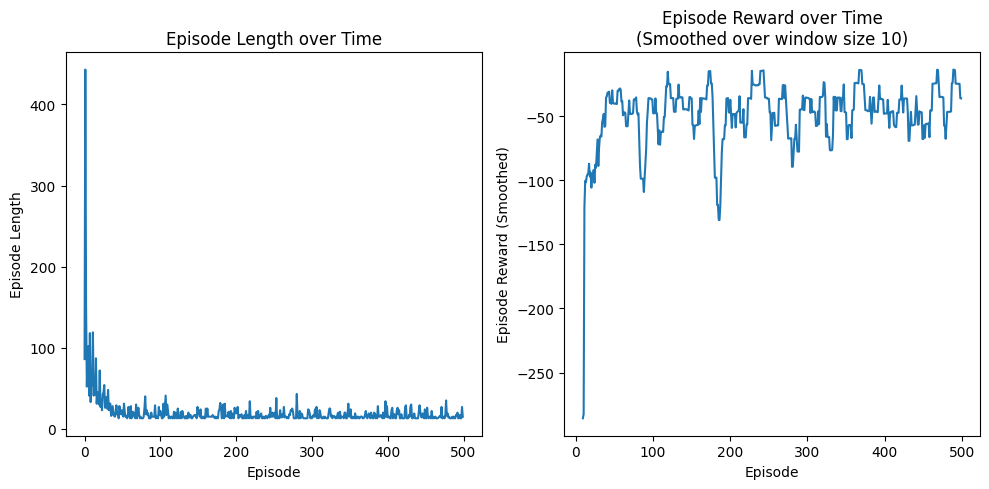

In [10]:
smoothing_window=10
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()


Lastly, we can also look at how our policy behaves by plotting the action it would take for each state.

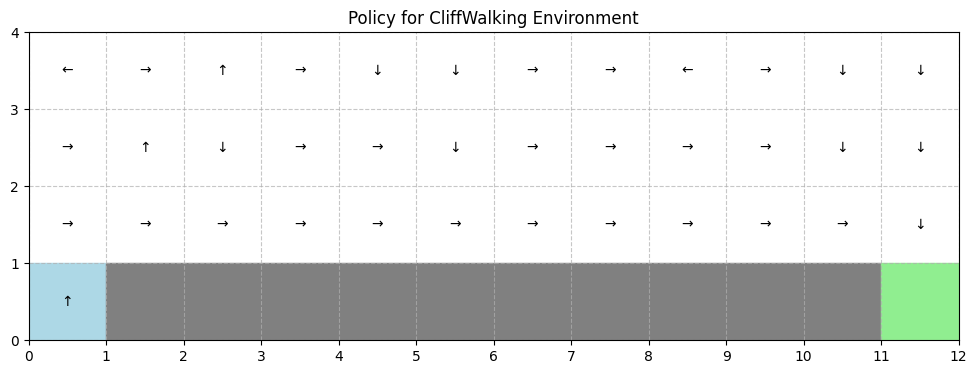

In [12]:
# Get policy
policy = make_epsilon_greedy_policy(Q, epsilon=0., num_actions=env.action_space.n)

# Define mapping for action representation
ACTION_SYMBOLS = {
    0: '↑',
    1: '→',
    2: '↓',
    3: '←',
}

plt.figure(figsize=(12, 4))

for x in range(12):
    for y in range(4):
        obs = x + 12 * y
        action = policy(obs)
        
        # Set colors for specific boxes
        box_color = 'white'
        text_color = 'black'
        if x == 0 and y == 3:
            box_color = 'lightblue'
        elif x == 11 and y == 3:
            box_color = 'lightgreen'
            text_color = box_color
        elif y == 3:
            box_color = 'grey'
            text_color = box_color

        plt.gca().add_patch(plt.Rectangle((x, 3-y), 1, 1, fill=True, color=box_color))
        plt.text(x + 0.5, (3-y) + 0.5, ACTION_SYMBOLS[action], ha='center', va='center', color=text_color)

plt.title('Policy for CliffWalking Environment')
plt.xticks(range(12+1))
plt.yticks(range(4+1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

---
<span style="color:orange">**EXERCISE**</span>: **Interpreting training results** (2 points)
1. Did the training converge? Why do you think so or not?
2. Explain why the episode reward does not converge smoothly towards the minimum value of $-13$? How could we fix that? 

**Your answers:**
1. The training has converged because, starting from the initial state, our greedy policy leads us on an optimal path to the goal. (1 point)

    Note: We also accepted as an answer that the training *did not* converge if the explanation was that the policy did not produce the optimal action for all states. Be aware that in high-dimensional problems we generally cannot ensure that our policy will produce the optimal action for every state and we consider it converged if the episodic reward reaches a local maximum.

2. As our policy is still exploring because we have a fixed $\epsilon > 0$, and thus we sometimes select suboptimal actions leading to a worse episodic reward. One solution would be to decay $\epsilon$ during training. (1 point)

Lastly, let us see what the learned policy does in action.

In [ ]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=500):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=20):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(obs)
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        if terminated or truncated:
            break
    
    return imgs

policy = make_epsilon_greedy_policy(Q, epsilon=0., num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "cliff_walking_trained.gif")
IImage(filename="cliff_walking_trained.gif")

---
<span style="color:orange">**EXERCISE**</span>: **Going beyond tabular approaches** (2 points)

Why is tabular Q-learning not a feasible approach for high-dimensional problems? How could we represent our Q-function instead?


**Your answer:** 
The number of entries in our tables grows exponentially with the dimensionality of our problem. Not only would it become infeasible to store all the state-action pairs, but the time to update all the values would be far too long. Instead, we could represent our Q-function with a neural network that can generalize values for unseen states.